## Bonus Task) Although residual networks are among the powerful classification models, their applications are not restricted only to the image classification models. In fact, for many different architectures, it would be useful to replace the conventional convolutional layers with residual blocks. Implement the AlexNet architecture with residual blocks and classify the Skin images. Then, compare the results between the original AlexNet and the one with residual blocks for the same hyperparameter values (e.g., n_base, batch_s, n_epoch, ...).

In [1]:
# Data Loader
import os
import numpy as np
from random import shuffle
from skimage.io import imread
from skimage.transform import resize

# import tensorflow packages
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Activation, Dropout, Input, Add
from tensorflow.keras.models import Model

# import pyplot
import matplotlib.pyplot as plt

In [2]:
def gen_labels(im_name, pat1, pat2):
    '''
    Parameters
    ----------
    im_name : Str
    The image file name.
    pat1 : Str
    A string pattern in the filename for 1st class, e.g "Mel"
    pat2 : Str
    A string pattern in the filename 2nd class, e.g, "Nev"
    Returns
    -------
    Label : Numpy array
    Class label of the filename name based on its pattern.
    '''
    if pat1 in im_name:
        label = np.array([0])
    elif pat2 in im_name:
        label = np.array([1])
    return label

def get_data(data_path, data_list, img_h, img_w):
    """
    Parameters
    ----------
    train_data_path : Str
    Path to the data directory
    train_list : List
    A list containing the name of the images.
    img_h : Int
    image height to be resized to.
    img_w : Int
    image width to be resized to.
    Returns
    -------
    img_labels : Nested List
    A nested list containing the loaded images along with their
    correcponding labels.
    """
    img_labels = []
    for item in enumerate(data_list):
        img = imread(os.path.join(data_path, item[1]), as_gray = True) # "as_grey"
        img = resize(img, (img_h, img_w), anti_aliasing = True).astype('float32')
        img_labels.append([np.array(img), gen_labels(item[1], 'Mel', 'Nev')])
        if item[0] % 100 == 0:
            print('Reading: {0}/{1} of train images'.format(item[0], len(data_list)))
        
    shuffle(img_labels)
    return img_labels

def get_data_arrays(nested_list, img_h, img_w):
    """
    Parameters
    ----------
    nested_list : nested list
    nested list of image arrays with corresponding class labels.
    img_h : Int
    Image height.
    img_w : Int
    Image width.

    Returns
    -------
    img_arrays : Numpy array
    4D Array with the size of (n_data,img_h,img_w, 1)
    label_arrays : Numpy array
    1D array with the size (n_data).
    """
    img_arrays = np.zeros((len(nested_list), img_h, img_w), dtype = np.float32)
    label_arrays = np.zeros((len(nested_list)), dtype = np.int32)
    
    for ind in range(len(nested_list)):
        img_arrays[ind] = nested_list[ind][0]
        label_arrays[ind] = nested_list[ind][1]
    
    img_arrays = np.expand_dims(img_arrays, axis =3)    
    return img_arrays, label_arrays

def get_train_test_arrays(train_data_path, test_data_path, train_list,
                          test_list, img_h, img_w):
    """
    Get the directory to the train and test sets, the files names and
    the size of the image and return the image and label arrays for
    train and test sets.
    """
    train_data = get_data(train_data_path, train_list, img_h, img_w)
    test_data = get_data(test_data_path, test_list, img_h, img_w)
    train_img, train_label = get_data_arrays(train_data, img_h, img_w)
    test_img, test_label = get_data_arrays(test_data, img_h, img_w)
    del(train_data)
    del(test_data)
    return train_img, test_img, train_label, test_label

img_w, img_h = 128, 128 # Setting the width and heights of the images.
data_path = '/DL_course_data/Lab1/Skin/' # Path to data root with two subdirs.
train_data_path = os.path.join(data_path, 'train')
test_data_path = os.path.join(data_path, 'test')
train_list = os.listdir(train_data_path)
test_list = os.listdir(test_data_path)
x_train, x_test, y_train, y_test = get_train_test_arrays(train_data_path, test_data_path, train_list,
                                                         test_list, img_h, img_w)

Reading: 0/1000 of train images
Reading: 100/1000 of train images
Reading: 200/1000 of train images
Reading: 300/1000 of train images
Reading: 400/1000 of train images
Reading: 500/1000 of train images
Reading: 600/1000 of train images
Reading: 700/1000 of train images
Reading: 800/1000 of train images
Reading: 900/1000 of train images
Reading: 0/200 of train images
Reading: 100/200 of train images


In [3]:
do_rate = 0.7
def AlexNet(img_ch, img_width, img_height, n_filters_init):
    
    model = Sequential()
    
    model.add(Conv2D(filters=n_filters_init, input_shape=(img_width, img_height, img_ch),
                     kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(filters=n_filters_init*2, kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(filters=n_filters_init*4, kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))

    model.add(Conv2D(filters=n_filters_init*4, kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))

    model.add(Conv2D(filters=n_filters_init*2, kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(Dropout(do_rate))
    model.add(Activation('relu'))

    model.add(Dense(64))
    model.add(Dropout(do_rate))
    model.add(Activation('relu'))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.summary()   
    return model

In [22]:
def ResAlexNet(img_ch, img_width, img_height, n_filters_init, do_rate):
    input_size = (img_width, img_height, img_ch)
    input_layer = Input(shape=input_size, name="input_layer")
    
    x1 = Conv2D(filters=n_filters_init, input_shape=(img_width, img_height, img_ch),
                     kernel_size=(3,3), strides=(1,1), padding='same')(input_layer)
    x1 = Activation('relu')(x1)
    x1 = MaxPooling2D(pool_size=(2,2))(x1)
    
    x2 = Conv2D(filters=n_filters_init*2, kernel_size=(3,3), strides=(1,1), padding='same')(x1)
    x2 = Activation('relu')(x2)
    x2 = MaxPooling2D(pool_size=(2,2))(x2)
    
    x3 = Conv2D(filters=n_filters_init*4, kernel_size=(3,3), strides=(1,1), padding='same')(x2)
    
    # add first skip connection
    skip_1 = MaxPooling2D(pool_size=(2,2))(x1)
    # upscale dimensionality
    skip_1 = Conv2D(filters=n_filters_init*4, kernel_size=1, strides=1, padding='same')(skip_1)
    add_1 = Add()([skip_1, x3])
    
    x4_input = Activation('relu')(add_1)
    x4 = Conv2D(filters=n_filters_init*2, kernel_size=(3,3), strides=(1,1), padding='same')(x4_input)
    x4 = Activation('relu')(x4)
    x4 = MaxPooling2D(pool_size=(2,2))(x4)
    
    x5 = Conv2D(filters=n_filters_init*2, kernel_size=(3,3), strides=(1,1), padding='same')(x4)
    skip_2 = MaxPooling2D(pool_size=(2,2))(x4_input)
    skip_2 = Conv2D(filters=n_filters_init*2, kernel_size=1, strides=1, padding='same')(skip_2)
    add_2 = Add()([skip_2, x5])
    x5 = Activation('relu')(add_2)
    
    
    dense_1 = MaxPooling2D(pool_size=(2,2))(x5)
    dense_1 = Flatten()(dense_1)
    dense_1 = Dense(128)(dense_1)
    dense_1 = Dropout(do_rate)(dense_1)
    dense_1 = Activation('relu')(dense_1)
    
    dense_2 = Dense(64)(dense_1)
    dense_2 = Dropout(do_rate)(dense_2)
    dense_2 = Activation('relu')(dense_2)
    
    output = Dense(1)(dense_2)
    output = Activation('sigmoid')(output)
    
    clf = Model(inputs=input_layer, outputs=output)
    clf.summary
    return clf
    
    
    

In [23]:
batch_size = 32
epochs = 100
n_base = 8
learning_rate = 0.0001
do_rate = 0.7


clf_ResAlex = ResAlexNet(1, 128, 128, n_base, do_rate)
clf_ResAlex.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()])

clf_ResAlex_hist = clf_ResAlex.fit(
                                    x=x_train,
                                    y=y_train,
                                    batch_size=batch_size,
                                    epochs=epochs,
                                    verbose=1,
                                    validation_data=(x_test, y_test),
                                    shuffle=False,                                    
                                    )

Train on 1000 samples, validate on 200 samples
Epoch 1/100
1000/1000 [==============================] - 1s 720us/sample - loss: 0.7058 - binary_accuracy: 0.4950 - val_loss: 0.6933 - val_binary_accuracy: 0.5050
Epoch 2/100
1000/1000 [==============================] - 0s 314us/sample - loss: 0.6952 - binary_accuracy: 0.5020 - val_loss: 0.6931 - val_binary_accuracy: 0.5150
Epoch 3/100
1000/1000 [==============================] - 0s 315us/sample - loss: 0.6931 - binary_accuracy: 0.5220 - val_loss: 0.6930 - val_binary_accuracy: 0.5050
Epoch 4/100
1000/1000 [==============================] - 0s 311us/sample - loss: 0.6942 - binary_accuracy: 0.5070 - val_loss: 0.6931 - val_binary_accuracy: 0.5000
Epoch 5/100
1000/1000 [==============================] - 0s 307us/sample - loss: 0.6983 - binary_accuracy: 0.5010 - val_loss: 0.6929 - val_binary_accuracy: 0.5000
Epoch 6/100
1000/1000 [==============================] - 0s 315us/sample - loss: 0.6933 - binary_accuracy: 0.5210 - val_loss: 0.6926 - val

Epoch 51/100
1000/1000 [==============================] - 0s 301us/sample - loss: 0.5562 - binary_accuracy: 0.7570 - val_loss: 0.5490 - val_binary_accuracy: 0.7600
Epoch 52/100
1000/1000 [==============================] - 0s 308us/sample - loss: 0.5619 - binary_accuracy: 0.7470 - val_loss: 0.5305 - val_binary_accuracy: 0.8050
Epoch 53/100
1000/1000 [==============================] - 0s 304us/sample - loss: 0.5435 - binary_accuracy: 0.7600 - val_loss: 0.5178 - val_binary_accuracy: 0.8200
Epoch 54/100
1000/1000 [==============================] - 0s 298us/sample - loss: 0.5571 - binary_accuracy: 0.7540 - val_loss: 0.5151 - val_binary_accuracy: 0.8150
Epoch 55/100
1000/1000 [==============================] - 0s 302us/sample - loss: 0.5510 - binary_accuracy: 0.7580 - val_loss: 0.5160 - val_binary_accuracy: 0.8100
Epoch 56/100
1000/1000 [==============================] - 0s 311us/sample - loss: 0.5599 - binary_accuracy: 0.7450 - val_loss: 0.5179 - val_binary_accuracy: 0.8150
Epoch 57/100
100

dict_keys(['loss', 'val_binary_accuracy', 'val_loss', 'binary_accuracy'])
Training binary_accuracy 0.812
Validation accuracy 0.835


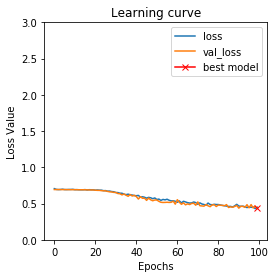

(0, 1)

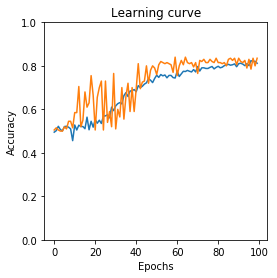

In [25]:
plt.figure(figsize=(4, 4))
plt.title("Learning curve")
plt.plot(clf_ResAlex_hist.history["loss"], label="loss") #loss is training loss
plt.plot(clf_ResAlex_hist.history["val_loss"], label="val_loss") #val_loss is validation loss
plt.plot(np.argmin(clf_ResAlex_hist.history["val_loss"]),
np.min(clf_ResAlex_hist.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.ylim((0,3))

plt.legend();
print(clf_ResAlex_hist.history.keys())
print("Training binary_accuracy", clf_ResAlex_hist.history["binary_accuracy"][-1])
print("Validation accuracy", clf_ResAlex_hist.history["val_binary_accuracy"][-1])
plt.show()

# plotting accuracy curves
plt.figure(figsize=(4, 4))
plt.title("Learning curve")
plt.plot(clf_ResAlex_hist.history["binary_accuracy"], label="binary_accuracy") # training accuracy
plt.plot(clf_ResAlex_hist.history["val_binary_accuracy"], label="val_binary_accuracy") # validation accuracy
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim((0,1))

In [19]:
# AlexNet without residual blocks
batch_size = 32
epochs = 100
n_base = 8
learning_rate = 0.0001


clf_Alex = AlexNet(1, 128, 128, n_base)
clf_Alex.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()])

clf_Alex_hist = clf_Alex.fit(
                                    x=x_train,
                                    y=y_train,
                                    batch_size=batch_size,
                                    epochs=epochs,
                                    verbose=1,
                                    validation_data=(x_test, y_test),
                                    shuffle=False,                                    
                                    )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 128, 128, 8)       80        
_________________________________________________________________
activation_40 (Activation)   (None, 128, 128, 8)       0         
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 64, 64, 16)        1168      
_________________________________________________________________
activation_41 (Activation)   (None, 64, 64, 16)        0         
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 32, 32, 32)        4

Epoch 31/100
1000/1000 [==============================] - 0s 275us/sample - loss: 0.6032 - binary_accuracy: 0.7030 - val_loss: 0.5743 - val_binary_accuracy: 0.7450
Epoch 32/100
1000/1000 [==============================] - 0s 271us/sample - loss: 0.5941 - binary_accuracy: 0.7030 - val_loss: 0.6055 - val_binary_accuracy: 0.6300
Epoch 33/100
1000/1000 [==============================] - 0s 278us/sample - loss: 0.5850 - binary_accuracy: 0.7160 - val_loss: 0.5241 - val_binary_accuracy: 0.8150
Epoch 34/100
1000/1000 [==============================] - 0s 268us/sample - loss: 0.5673 - binary_accuracy: 0.7320 - val_loss: 0.5529 - val_binary_accuracy: 0.7600
Epoch 35/100
1000/1000 [==============================] - 0s 272us/sample - loss: 0.5794 - binary_accuracy: 0.7210 - val_loss: 0.5252 - val_binary_accuracy: 0.8100
Epoch 36/100
1000/1000 [==============================] - 0s 269us/sample - loss: 0.5679 - binary_accuracy: 0.7250 - val_loss: 0.5518 - val_binary_accuracy: 0.7700
Epoch 37/100
100

Epoch 81/100
1000/1000 [==============================] - 0s 283us/sample - loss: 0.4652 - binary_accuracy: 0.8050 - val_loss: 0.4443 - val_binary_accuracy: 0.8200
Epoch 82/100
1000/1000 [==============================] - 0s 282us/sample - loss: 0.4602 - binary_accuracy: 0.7860 - val_loss: 0.4414 - val_binary_accuracy: 0.8250
Epoch 83/100
1000/1000 [==============================] - 0s 276us/sample - loss: 0.4593 - binary_accuracy: 0.8200 - val_loss: 0.4431 - val_binary_accuracy: 0.8100
Epoch 84/100
1000/1000 [==============================] - 0s 270us/sample - loss: 0.4579 - binary_accuracy: 0.8140 - val_loss: 0.4513 - val_binary_accuracy: 0.8050
Epoch 85/100
1000/1000 [==============================] - 0s 273us/sample - loss: 0.4593 - binary_accuracy: 0.8100 - val_loss: 0.4423 - val_binary_accuracy: 0.8100
Epoch 86/100
1000/1000 [==============================] - 0s 285us/sample - loss: 0.4482 - binary_accuracy: 0.8140 - val_loss: 0.4289 - val_binary_accuracy: 0.8100
Epoch 87/100
100

dict_keys(['loss', 'val_binary_accuracy', 'val_loss', 'binary_accuracy'])
Training binary_accuracy 0.817
Validation accuracy 0.805


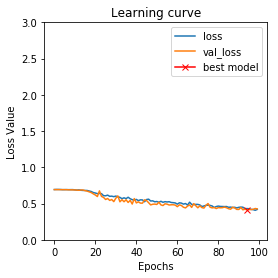

(0, 1)

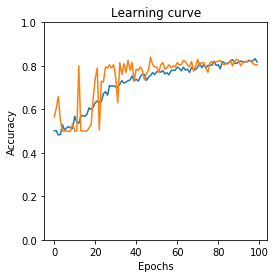

In [21]:
plt.figure(figsize=(4, 4))
plt.title("Learning curve")
plt.plot(clf_Alex_hist.history["loss"], label="loss") #loss is training loss
plt.plot(clf_Alex_hist.history["val_loss"], label="val_loss") #val_loss is validation loss
plt.plot(np.argmin(clf_Alex_hist.history["val_loss"]),
np.min(clf_Alex_hist.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.ylim((0,3))

plt.legend();
print(clf_Alex_hist.history.keys())
print("Training binary_accuracy", clf_Alex_hist.history["binary_accuracy"][-1])
print("Validation accuracy", clf_Alex_hist.history["val_binary_accuracy"][-1])
plt.show()

# plotting accuracy curves
plt.figure(figsize=(4, 4))
plt.title("Learning curve")
plt.plot(clf_Alex_hist.history["binary_accuracy"], label="binary_accuracy") # training accuracy
plt.plot(clf_Alex_hist.history["val_binary_accuracy"], label="val_binary_accuracy") # validation accuracy
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim((0,1))

### Then, compare the results between the original AlexNet and the one with residual blocks for the same hyperparameter values (e.g., n_base, batch_s, n_epoch, ...).

The validation accuracy for the model with the residual blocks is 0.84 while the validation accuracy without is 0.81. Thus, the addidtion of the residual blocks improved performance without adding overfitting. 